# Attempt for making regressor for score atribute
---
In this notebook we will try to obtain model capable of calcultaing score for tf-idf text vectors.

In [1]:
# imports

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import pandas as pd

### Data loading

---

In [2]:
# Function to load data into a DataFrame
def load_data_to_dataframe():
    try:
        # Establish a connection to the PostgreSQL database
        connection = psycopg2.connect(
            host='10.10.10.10',  # Replace with your host
            port=5432,           # Default PostgreSQL port
            user='postgres',     # Replace with your username
            password='adm',      # Replace with your password
            database='adm'       # Replace with your database name
        )
        
        # Create a SQL query to retrieve 10,000 records
        query = "SELECT body, score FROM cleared_10 LIMIT 20000;"

        # Load the data into a pandas DataFrame
        df = pd.read_sql_query(query, connection)

    except Exception as e:
        print("An error occurred:", e)

    finally:
        # Close the connection
        if connection:
            connection.close()
    
    return df

# Call the function to load data into a DataFrame
data = load_data_to_dataframe()
df = pd.DataFrame(data[['body', 'score']].values, columns=["text", 'score'])

C:\Users\Marcin\AppData\Local\Temp\ipykernel_29832\4215962390.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [3]:
df.head()

,text,score
0,Here is a list of video links collected from c...,1
1,"&gt;he might still sell her to someone else, w...",11
2,The thing about Dishonored is that although it...,0
3,"Hi there, I'm the Director of Partnerships at ...",28
4,"Also, if your intention is not to seem argumen...",-8


In [4]:
df.score.isna().unique()

array([False])

### Data clearing
---

In [5]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Ensure consistent language detection
DetectorFactory.seed = 0

# Function to check if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, consider it non-English
    
print('Before filtering for English laguage: ', df.shape)

# Filter DataFrame to keep only English texts
df = df[df['text'].apply(is_english)]

print('After filtering for English laguage: ', df.shape)

Before filtering for English laguage:  (20000, 2)
After filtering for English laguage:  (19840, 2)


In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.head()

,text,score,clean_text
0,Here is a list of video links collected from c...,1,list video link collect comment redditor made ...
1,"&gt;he might still sell her to someone else, w...",11,gt might still sell someon els still nefari in...
2,The thing about Dishonored is that although it...,0,thing dishonor although possibl thing shown vi...
3,"Hi there, I'm the Director of Partnerships at ...",28,hi director partnership twitch verif https twi...
4,"Also, if your intention is not to seem argumen...",-8,also intent seem argument condescend thing wou...


### TF-IDF transformation
---

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=50)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [9]:
X_tfidf.shape

(19840, 50)

### Linear Regression Model
---

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
X = X_tfidf
y = df['score'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2084.3311386961836


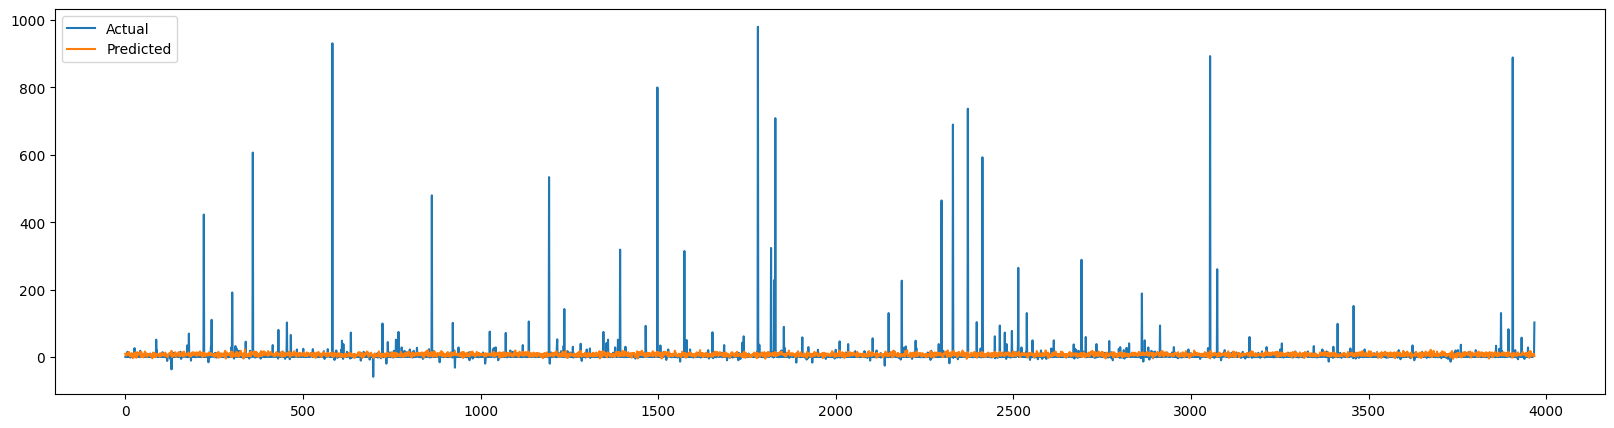

In [15]:
plt.figure(figsize=(20,5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [16]:
import random
for i in random.sample(range(len(y_test)), 20):
    prediction = model.predict(X_tfidf[i])
    print(f"Predicted score: {prediction}, true score: {y_test[i]}")

Predicted score: [8.61916779], true score: -1
Predicted score: [9.32018308], true score: 1
Predicted score: [6.47694718], true score: 9
Predicted score: [1.4034709], true score: 2
Predicted score: [4.89858348], true score: 5
Predicted score: [10.66228215], true score: 5
Predicted score: [5.26756214], true score: 1
Predicted score: [2.98852159], true score: 2
Predicted score: [12.23938217], true score: 1
Predicted score: [6.32893029], true score: 2
Predicted score: [12.89601607], true score: -2
Predicted score: [10.30215261], true score: 3
Predicted score: [5.59211623], true score: 1
Predicted score: [14.63926916], true score: 2
Predicted score: [8.23202187], true score: 9
Predicted score: [7.06936151], true score: 3
Predicted score: [17.82633856], true score: 1
Predicted score: [4.78505467], true score: 6
Predicted score: [12.92576275], true score: -2
Predicted score: [5.46209184], true score: 6


In [17]:
# create low score mask for scoores less than 15 and greater than -15
low_scores_mask = (df['score'] < 15) & (df['score'] > -15)

X = X_tfidf[low_scores_mask]
y = df[low_scores_mask]['score'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9.022208543631882


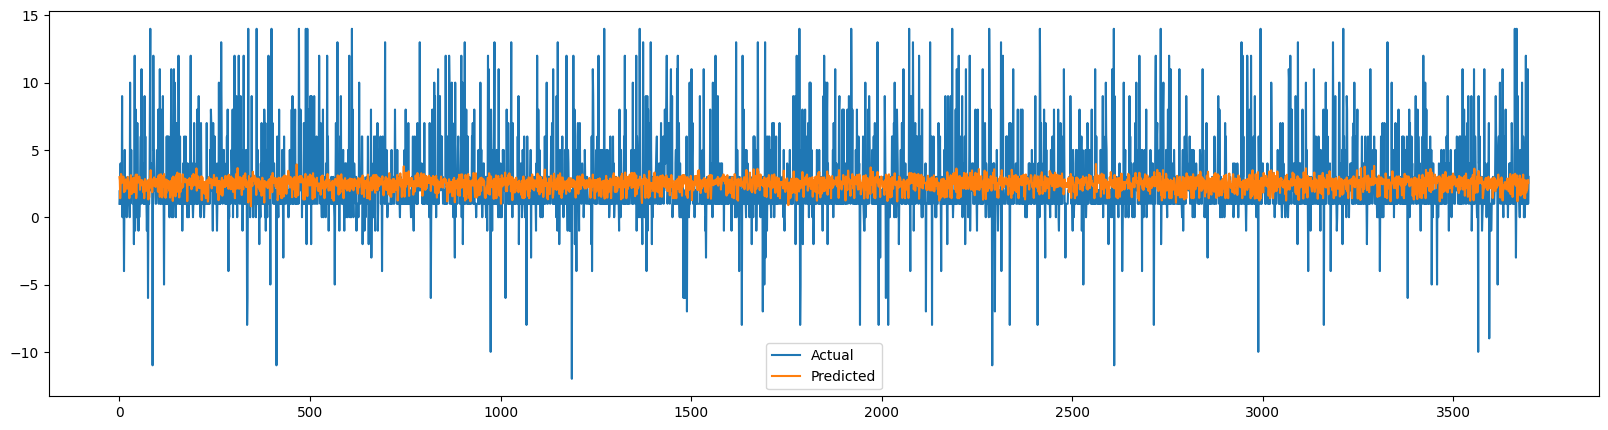

In [21]:
plt.figure(figsize=(20,5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [22]:
for i in random.sample(range(len(y_test)), 20):
    prediction = model.predict(X_tfidf[i])
    print(f"Predicted score: {prediction}, true score: {y_test[i]}")

Predicted score: [1.63171902], true score: 2
Predicted score: [2.61194144], true score: 1
Predicted score: [2.55356139], true score: 10
Predicted score: [2.42811933], true score: 3
Predicted score: [2.64675159], true score: 2
Predicted score: [1.54852336], true score: 2
Predicted score: [1.41247202], true score: 2
Predicted score: [2.0764124], true score: 8
Predicted score: [3.40925361], true score: 8
Predicted score: [2.13060459], true score: 2
Predicted score: [2.77690928], true score: 2
Predicted score: [1.50001461], true score: 2
Predicted score: [2.69973424], true score: 1
Predicted score: [1.34608202], true score: 8
Predicted score: [3.05912413], true score: 3
Predicted score: [1.63395513], true score: 6
Predicted score: [2.02078181], true score: 1
Predicted score: [2.14119206], true score: 4
Predicted score: [1.45642679], true score: 3
Predicted score: [3.02378267], true score: 2


### BERT Model
---

In [53]:
from transformers import BertTokenizer, BertModel
from transformers import BartTokenizer, BartModel, AdamW
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Adam

In [54]:
texts = df['clean_text'].values[:200]
scores = df['score'].values[:200]

In [55]:
class TextScoreDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_len):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        score = self.scores[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'score': torch.tensor(score, dtype=torch.float)
        }

In [62]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_len = 64  # Adjust based on your text length
dataset = TextScoreDataset(texts, scores, tokenizer, max_len)
train_data, val_data = train_test_split(dataset, test_size=0.2)

In [63]:
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2)

In [64]:
class BartForScoreRegression(nn.Module):
    def __init__(self):
        super(BartForScoreRegression, self).__init__()
        self.bart = BartModel.from_pretrained('facebook/bart-base')
        self.regressor = nn.Linear(self.bart.config.hidden_size, 1)  # Regression head

    def forward(self, input_ids, attention_mask):
        outputs = self.bart(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Take the representation of the [CLS] token
        score = self.regressor(pooled_output)
        return score.squeeze(-1)  # Squeeze to get a single value per input

In [65]:
model = BartForScoreRegression()
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

In [66]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)
        
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, scores)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):  # Adjust epochs
    avg_loss = train_model(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}: Loss = {avg_loss}")

Epoch 1: Loss = 1513.416138162464
Epoch 2: Loss = 1515.8205627825112
Epoch 3: Loss = 1508.8974808111786


In [69]:
def evaluate_model(model, val_loader):
    model.eval()
    predictions = []
    actual_scores = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['score'].to(device)
            
            predicted_scores = model(input_ids, attention_mask)
            predictions.extend(predicted_scores.cpu().numpy())
            actual_scores.extend(scores.cpu().numpy())
    
    return predictions, actual_scores

predictions, actual_scores = evaluate_model(model, val_loader)
print(predictions)
print(actual_scores)


[8.694911, 9.042572, 8.886148, 8.739177, 8.4002695, 8.613721, 8.675097, 9.233256, 8.75619, 9.108065, 8.610878, 8.998914, 8.645062, 9.106659, 9.030753, 8.807901, 9.353527, 9.277435, 9.422249, 8.841294, 8.978169, 8.873771, 8.946309, 9.290467, 8.849938, 8.682128, 8.879461, 9.005252, 8.89484, 9.148102, 9.046596, 8.672774, 8.975213, 8.37801, 8.779525, 8.803214, 9.274651, 8.835255, 8.537148, 8.879523]
[1.0, 2.0, 1.0, 1.0, 3.0, 5.0, 0.0, 1.0, 2.0, -5.0, 0.0, 18.0, 1.0, 1.0, 1.0, 1.0, 2.0, 11.0, 1.0, 4.0, 3.0, 19.0, 1.0, 10.0, 26.0, 2.0, 17.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 7.0, 2.0, 5.0, 2.0, 1.0]


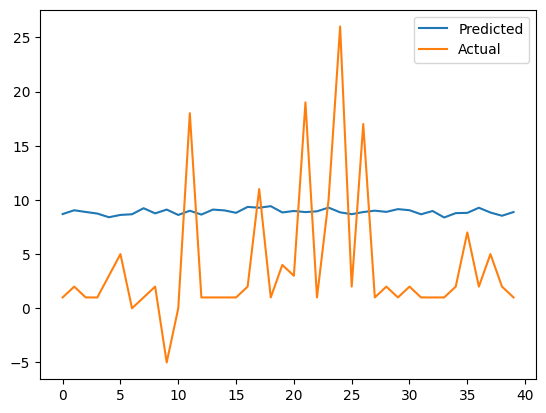

In [70]:
plt.plot(predictions, label='Predicted')
plt.plot(actual_scores, label='Actual')
plt.legend()
plt.show()

### Dense Neural Network
---

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [72]:
X = X_tfidf.toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
y = df['score'].values.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8)

In [ ]:
class DenseNNForRegression(nn.Module):
    def __init__(self, input_dim):
        super(DenseNNForRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
input_dim = X_train.shape[1]
model = DenseNNForRegression(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
# Step 7: Training the Model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/50], Train Loss: 4450.2698, Val Loss: 2069.9635
Epoch [2/50], Train Loss: 4434.6612, Val Loss: 2066.0095
Epoch [3/50], Train Loss: 4420.8185, Val Loss: 2067.4763
Epoch [4/50], Train Loss: 4400.4645, Val Loss: 2070.2852
Epoch [5/50], Train Loss: 4365.4568, Val Loss: 2082.0835
Epoch [6/50], Train Loss: 4279.8186, Val Loss: 2184.7985
Epoch [7/50], Train Loss: 4042.9915, Val Loss: 2296.8682
Epoch [8/50], Train Loss: 3658.1757, Val Loss: 2190.1890
Epoch [9/50], Train Loss: 3132.1415, Val Loss: 2532.7637
Epoch [10/50], Train Loss: 1858.9695, Val Loss: 2552.8227
Epoch [11/50], Train Loss: 1217.2798, Val Loss: 3962.5473
Epoch [12/50], Train Loss: 934.1998, Val Loss: 2939.3072
Epoch [13/50], Train Loss: 830.0870, Val Loss: 3080.7110
Epoch [14/50], Train Loss: 1252.4148, Val Loss: 2940.6828
Epoch [15/50], Train Loss: 947.6083, Val Loss: 2908.2879
Epoch [16/50], Train Loss: 1051.9340, Val Loss: 2653.0406
Epoch [17/50], Train Loss: 1076.9436, Val Loss: 3588.5257
Epoch [18/50], Train Loss:

Predictions: [3.3726206 4.2316294 3.865053  ... 4.169917  3.7615073 4.152566 ]
Actual Scores: [  1.   3.   3. ...   5.  12. 103.]


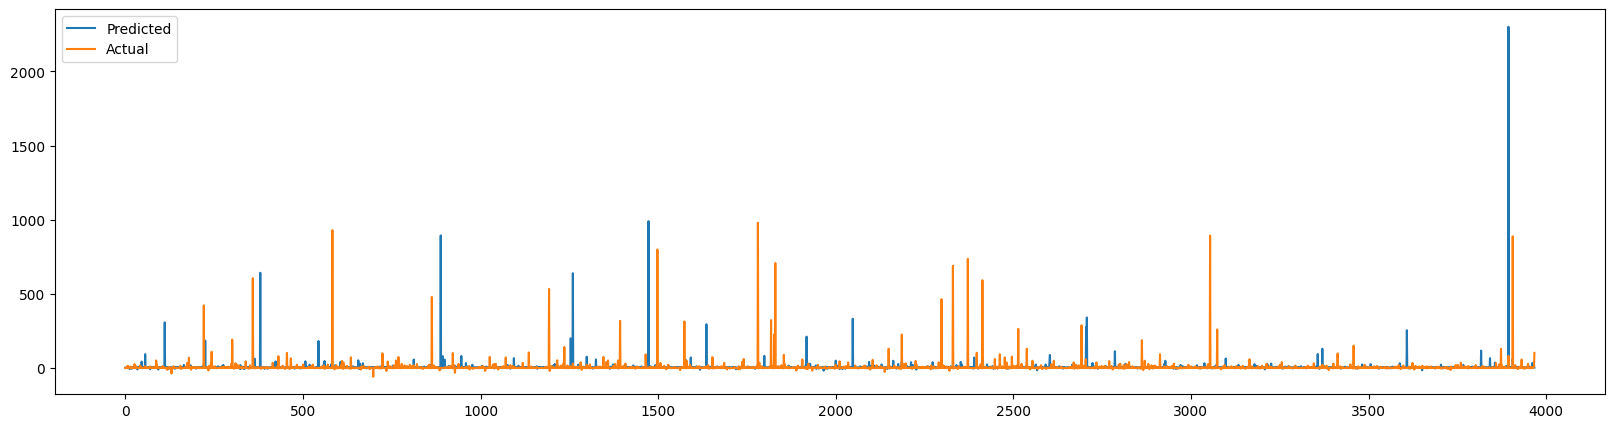

In [86]:
model.eval()
with torch.no_grad():
    predictions = model(X_val_tensor)

    print("Predictions:", predictions.flatten().numpy())
    print("Actual Scores:", y_val)

    plt.figure(figsize=(20,5))
    plt.plot(predictions.flatten().numpy(), label='Predicted')
    plt.plot(y_val, label='Actual')
    plt.legend()
    plt.show()

In [124]:
low_scores_mask = (df['score'] < 50) & (df['score'] > 0)

In [125]:
X = X_tfidf[low_scores_mask].toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [126]:
y = df[low_scores_mask]['score'].values.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [127]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8)

In [129]:
input_dim = X_train.shape[1]
model = DenseNNForRegression(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [130]:
# Step 7: Training the Model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/50], Train Loss: 35.8316, Val Loss: 35.7924
Epoch [2/50], Train Loss: 34.8399, Val Loss: 34.6908
Epoch [3/50], Train Loss: 34.4016, Val Loss: 34.8094
Epoch [4/50], Train Loss: 34.1018, Val Loss: 34.9750
Epoch [5/50], Train Loss: 33.7562, Val Loss: 35.0401
Epoch [6/50], Train Loss: 33.4746, Val Loss: 35.2464
Epoch [7/50], Train Loss: 33.2788, Val Loss: 35.0960
Epoch [8/50], Train Loss: 32.9004, Val Loss: 36.6168
Epoch [9/50], Train Loss: 32.4751, Val Loss: 35.4929
Epoch [10/50], Train Loss: 32.0198, Val Loss: 36.4681
Epoch [11/50], Train Loss: 31.1728, Val Loss: 36.6555
Epoch [12/50], Train Loss: 30.0199, Val Loss: 36.9295
Epoch [13/50], Train Loss: 28.0044, Val Loss: 38.8612
Epoch [14/50], Train Loss: 25.8994, Val Loss: 41.6393
Epoch [15/50], Train Loss: 23.3377, Val Loss: 40.8746
Epoch [16/50], Train Loss: 21.1782, Val Loss: 38.6523
Epoch [17/50], Train Loss: 19.2612, Val Loss: 41.1037
Epoch [18/50], Train Loss: 18.3244, Val Loss: 46.0469
Epoch [19/50], Train Loss: 16.8455, V

Predictions: [9.516904  1.8896514 2.2489748 ... 3.3521397 2.3667376 1.355956 ]
Actual Scores: [2. 2. 5. ... 1. 3. 5.]


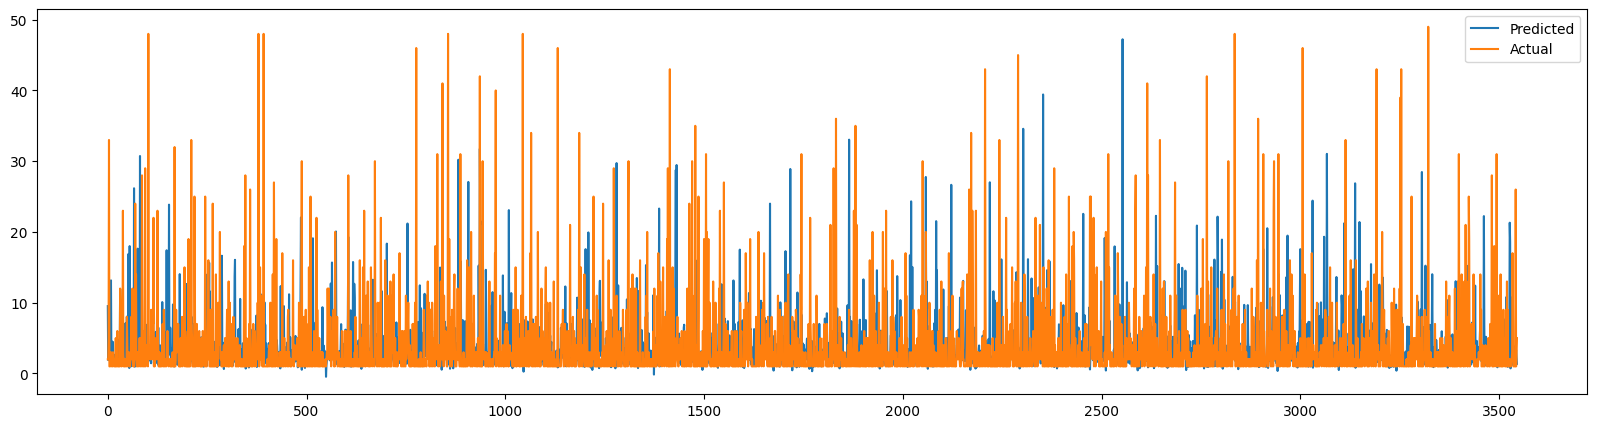

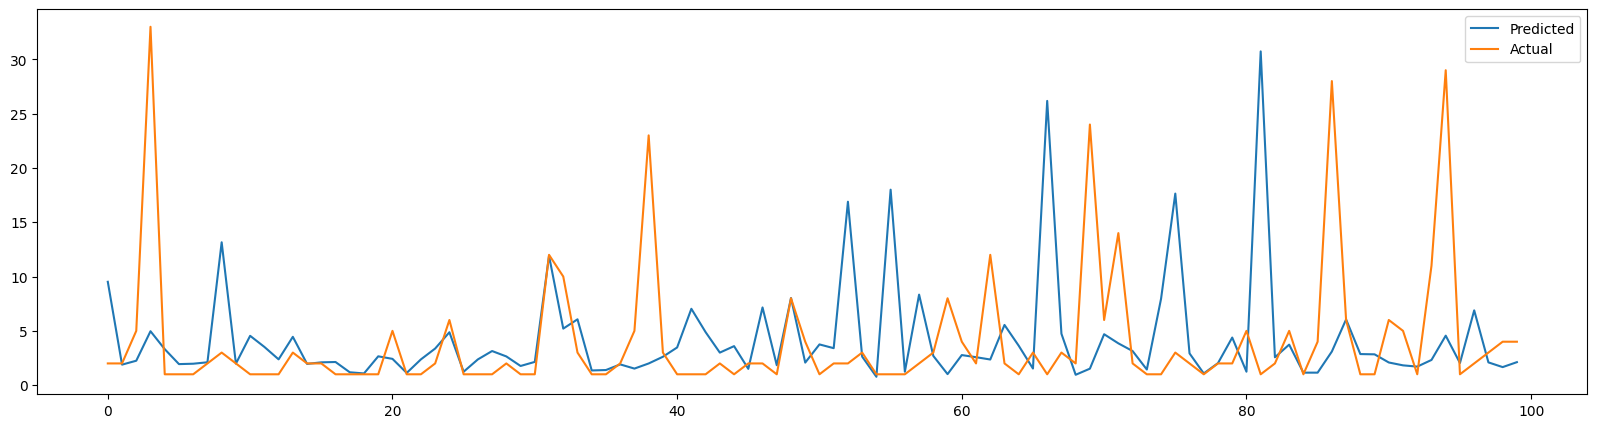

In [131]:
model.eval()
with torch.no_grad():
    predictions = model(X_val_tensor)

    print("Predictions:", predictions.flatten().numpy())
    print("Actual Scores:", y_val)

    plt.figure(figsize=(20,5))
    plt.plot(predictions.flatten().numpy(), label='Predicted')
    plt.plot(y_val, label='Actual')
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(predictions.flatten().numpy()[:100], label='Predicted')
    plt.plot(y_val[:100], label='Actual')
    plt.legend()
    plt.show()